# Libraries and Parse Data
Note: All computations were ran with last game weight hyperparameter `[0.4, 0.3, 0.2, 0.1]`

In [22]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import tabulate

UNNORMALIZE_FACTOR = 131  # MAX(HomeSpreadActual) - MIN(HomeSpreadActual)
UNNORMALIZE_FACTOR_PREDICT = 41
AVG_SIMULATE = 10

# REGRESSION
# Return X = testable features, Y = point spread
def spread_df_rgn(normalize=False, get_custom_date_range=False, substituted_spreads=None):
  data_df = pd.read_csv('combined_out.csv')

  real_cols = data_df.select_dtypes(include=['number']).columns

  if not get_custom_date_range:
    data_df = data_df.dropna(axis=0)

  if normalize:
    for col in real_cols:
      min_val = data_df[col].min()
      max_val = data_df[col].max()
      data_df[col] = (data_df[col] - min_val) / (max_val - min_val)

  if get_custom_date_range:
    data_df = data_df[(data_df['Date'] >= '2024-04-01') & (data_df['Date'] <= '2024-04-07')]
    data_df['HomeSpread'] = substituted_spreads
    data_df['HomeSpreadCorrectDirection'] = data_df['HomeSpreadActual'] > data_df['HomeSpread']
    data_df['HomeSpreadCorrectDirection'] = data_df['HomeSpreadCorrectDirection'].astype(int)
  
  data_df = data_df.drop('AwayTeam', axis=1)\
                   .drop('HomeTeam', axis=1)\
                   .drop('Date', axis=1)
  
  data_np = data_df.to_numpy()
  data_np = data_np[:, 5:]

  data_np = data_np.astype(float)

  return data_np[:, 1:-1], data_np[:, :1]

# CLASSIFICATION
# Return X = testable features, Y = correct point spread direction
def spread_df_cls(normalize=False, get_custom_date_range=False, substituted_spreads=None):
  data_df = pd.read_csv('combined_out.csv')

  real_cols = data_df.select_dtypes(include=['number']).columns

  if not get_custom_date_range:
    data_df = data_df.dropna(axis=0)

  if normalize:
    for col in real_cols:
      min_val = data_df[col].min()
      max_val = data_df[col].max()
      data_df[col] = (data_df[col] - min_val) / (max_val - min_val)

  if get_custom_date_range:
    data_df = data_df[(data_df['Date'] >= '2024-04-01') & (data_df['Date'] <= '2024-04-07')]
    data_df['HomeSpread'] = substituted_spreads
    data_df['HomeSpreadCorrectDirection'] = data_df['HomeSpreadActual'] > data_df['HomeSpread']
    data_df['HomeSpreadCorrectDirection'] = data_df['HomeSpreadCorrectDirection'].astype(int)

  data_df = data_df.drop('AwayTeam', axis=1)\
                   .drop('HomeTeam', axis=1)\
                   .drop('Date', axis=1)
  
  data_np = data_df.to_numpy()
  data_np = data_np[:, 5:]

  data_np = data_np.astype(float)

  return data_np[:, 1:-1], data_np[:, -1:]

# K-Neighbors Regressor
We are trying to calculate the true point differential of an NBA game.

## No Normalization and No Weighting

In [5]:
X, y = spread_df_rgn()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2)

i_idx = list(range(2, 11))
mae_list_a = [None, None]  # don't plot k=0,1

for i in range(2, 11):
  knn = KNeighborsRegressor(n_neighbors=i).fit(X_train, y_train)
  acc_train = knn.score(X_train, y_train)
  acc_test = knn.score(X_test, y_test)

  mae_train = mean_absolute_error(knn.predict(X_train), y_train)
  mae_test = mean_absolute_error(knn.predict(X_test), y_test)

  mae_list_a.append(mae_test)

# No Normalization and Weighting

In [2]:
X, y = spread_df_rgn()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2)

i_idx = list(range(2, 11))
mae_list_d = [None, None]  # don't plot k=0,1

for i in range(2, 11):
  knn = KNeighborsRegressor(n_neighbors=i).fit(X_train, y_train)
  acc_train = knn.score(X_train, y_train)
  acc_test = knn.score(X_test, y_test)

  mae_train = mean_absolute_error(knn.predict(X_train), y_train)
  mae_test = mean_absolute_error(knn.predict(X_test), y_test)

  mae_list_d.append(mae_test)

## Normalization without Weighting

In [3]:
X, y = spread_df_rgn(normalize=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2)

i_idx = list(range(2, 11))
mae_list_b = [None, None]  # don't plot k=0,1

for i in range(2, 11):
  knn = KNeighborsRegressor(n_neighbors=i, weights='distance').fit(X_train, y_train)
  acc_train = knn.score(X_train, y_train)
  acc_test = knn.score(X_test, y_test)

  mae_train = mean_absolute_error(knn.predict(X_train), y_train)
  mae_test = mean_absolute_error(knn.predict(X_test), y_test)

  mae_list_b.append(mae_test * UNNORMALIZE_FACTOR)

## Normalization and Weighting

In [23]:
X, y = spread_df_rgn(normalize=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2)

i_idx = list(range(2, 11))
mae_list_c = [None, None]  # don't plot k=0,1

for i in range(2, 11):
  knn = KNeighborsRegressor(n_neighbors=i, weights='distance').fit(X_train, y_train)
  acc_train = knn.score(X_train, y_train)
  acc_test = knn.score(X_test, y_test)

  mae_train = mean_absolute_error(knn.predict(X_train), y_train)
  mae_test = mean_absolute_error(knn.predict(X_test), y_test)

  mae_list_c.append(mae_test * UNNORMALIZE_FACTOR)

  k    No Norm/No Weight    No Norm/Weight    Norm/No Weight    Norm/Weight
---  -------------------  ----------------  ----------------  -------------
  2             11.7217           11.6909            11.8235        11.9414
  3             10.9068           10.9507            11.2023        11.1761
  4             10.5522           10.6733            10.8883        10.753
  5             10.3548           10.3722            10.6396        10.5252
  6             10.1513           10.2203            10.4885        10.4236
  7             10.0484           10.1207            10.3915        10.3031
  8              9.89787          10.0353            10.2966        10.2173
  9              9.79789          10.0015            10.2334        10.1374
 10              9.73632           9.93236           10.1923        10.1042


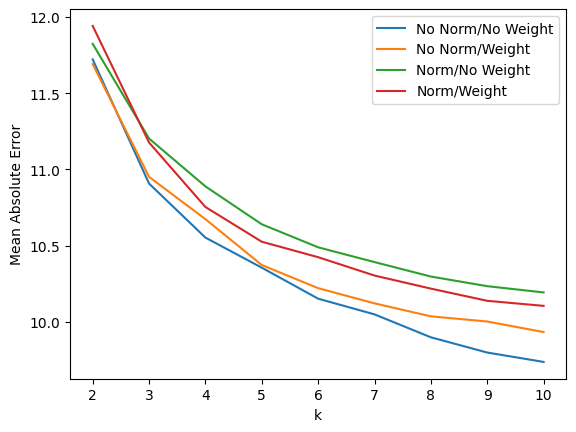

In [6]:
print(tabulate.tabulate([(x, y, z, a, b) for x, y, z, a, b in zip(i_idx, mae_list_a[2:], mae_list_d[2:], mae_list_b[2:], mae_list_c[2:])], headers=['k', 'No Norm/No Weight', 'No Norm/Weight', 'Norm/No Weight', 'Norm/Weight']))

plt.plot(mae_list_a)
plt.plot(mae_list_d)
plt.plot(mae_list_b)
plt.plot(mae_list_c)
plt.xlabel('k')
plt.ylabel('Mean Absolute Error')

plt.legend(['No Norm/No Weight', 'No Norm/Weight', 'Norm/No Weight', 'Norm/Weight'])

As k increases, MAE decreases, and in the best models can plateau a little under 10 (after adjusting for normalization). This means that the correct point differential is missed by about 10 points on average (showing that there is a lot of variability in NBA games that are difficult to explain statistically.)

# K-Neighbors Classifier
We are trying to estimate the point differential and compare it against the spread.

## Without Normalization

In [7]:
X, y = spread_df_cls()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2)

i_idx = list(range(2, 11))
acc_train_list_a = [None, None]  # don't plot k=0,1
acc_test_list_a = [None, None]   # don't plot k=0,1

for i in range(2, 11):
  train_curr = 0
  test_curr = 0

  for j in range(AVG_SIMULATE):
    knn = KNeighborsClassifier(n_neighbors=i).fit(X_train, np.ravel(y_train))
    acc_train = knn.score(X_train, y_train)
    acc_test = knn.score(X_test, y_test)

    train_curr += acc_train
    test_curr += acc_test

  acc_train_list_a.append(train_curr/AVG_SIMULATE)
  acc_test_list_a.append(test_curr/AVG_SIMULATE)

## With Normalization

In [24]:
X, y = spread_df_cls(normalize=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2)

i_idx = list(range(2, 11))
acc_train_list_b = [None, None]  # don't plot k=0,1
acc_test_list_b = [None, None]   # don't plot k=0,1

for i in range(2, 11):
  train_curr = 0
  test_curr = 0

  for j in range(AVG_SIMULATE):
    knn = KNeighborsClassifier(n_neighbors=i).fit(X_train, np.ravel(y_train))
    acc_train = knn.score(X_train, y_train)
    acc_test = knn.score(X_test, y_test)

    train_curr += acc_train
    test_curr += acc_test

  acc_train_list_b.append(acc_train)
  acc_test_list_b.append(acc_test)

  k    Non-normalized Test    Non-normalized Train    Normalized Test    Normalized Train
---  ---------------------  ----------------------  -----------------  ------------------
  2               0.514134                0.751278           0.495457            0.744904
  3               0.509086                0.747933           0.499495            0.749637
  4               0.516406                0.685327           0.500252            0.688608
  5               0.510348                0.68236            0.501767            0.688735
  6               0.514891                0.65295            0.5                 0.65314
  7               0.51161                 0.654402           0.501767            0.659325
  8               0.512115                0.632124           0.49899             0.636352
  9               0.515901                0.63591            0.495709            0.638877
 10               0.516153                0.623793           0.499748            0.624235


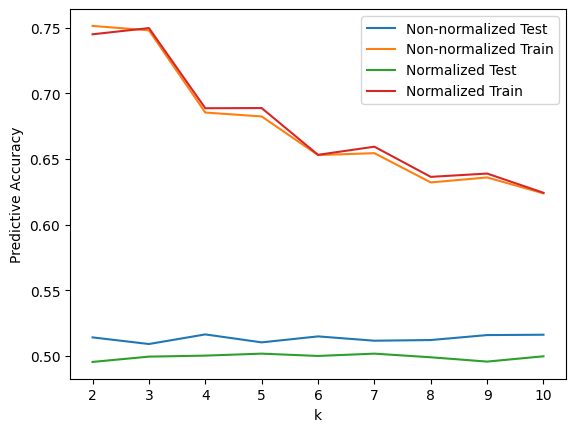

In [25]:
print(tabulate.tabulate([(x, y, z, a, b) for x, y, z, a, b in zip(i_idx, acc_test_list_a[2:], acc_train_list_a[2:], acc_test_list_b[2:], acc_train_list_b[2:])], headers=
                          ['k', 'Non-normalized Test', 'Non-normalized Train', 'Normalized Test', 'Normalized Train']
                        ))

plt.plot(acc_test_list_a)
plt.plot(acc_train_list_a)
plt.plot(acc_test_list_b)
plt.plot(acc_train_list_b)
plt.xlabel('k')
plt.ylabel('Predictive Accuracy')

plt.legend(['Non-normalized Test', 'Non-normalized Train', 'Normalized Test', 'Normalized Train'])

# Testing Novel Data
Testing all NBA games between April 1 and April 7, 2024.

In [12]:
new_point_spreads = [
  -18.5,
  -2.5,
  -12.5,
  -17.5,
  -1.5,
  -0.5,
  -15.5,
  -2.5,
  -7.5,
  9.5,
  -2.5,
  -2.5,
  -0.5,
  12.5,
  13.5,
  -4.5,
  -17.5,
  -12.5,
  -6.5,
  -12.5,
  -12.5,
  12.5,
  -1.5,
  6.5,
  -2.5,
  -3.5,
  3.5,
  3.5,
  -11.5,
  -14.5,
  -12.5,
  -4.5,
  1.5,
  -11.5,
  1.5,
  3.5,
  12.5,
  1.5,
  -2.5,
  -9.5,
  -6.5,
  -4.5,
  -10.5,
  15.5,
  -10.5,
  2.5,
  -12.5,
  10.5,
  3.5,
  -4.5,
  7.5,
  -4.5,
  -6.5,
  -16.5,
  -4.5,
  -9.5,
  -5.5,
  -2.5
]

accs = 0

for i in range(AVG_SIMULATE):
  X, y = spread_df_cls(normalize=False)
  X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2)
  knn = KNeighborsClassifier(n_neighbors=8).fit(X_train, np.ravel(y_train))

  X2, y2 = spread_df_cls(normalize=False, get_custom_date_range=True, substituted_spreads=new_point_spreads)
  acc = knn.score(X2, y2)
  accs += acc

print(f"Overall acc with k=8: {accs/AVG_SIMULATE}")

Overall acc with k=8: 0.48275862068965514


For a selection of recent games, the model was able to get on average 47% accurate. Interestingly enough, the non-weighted model performed better than the weighted model, with weighted being able to get as high as 52% accuracy. Weighted model struggled and got 49%.

# Grid Search

In [14]:
# GridSearch
param_grid = {
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2, 3, 4]
}

X, y = spread_df_cls()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2)

knn = KNeighborsClassifier(n_neighbors=10)
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, verbose=2)
grid_search.fit(X_train, np.ravel(y_train))

best_model = grid_search.best_estimator_
acc_train = best_model.score(X_train, y_train)
acc_test = best_model.score(X_test, y_test)

print(f"Accuracy: {acc_test}")
print("Best parameters:", grid_search.best_params_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END ...............algorithm=auto, p=1, weights=uniform; total time=   0.2s
[CV] END ...............algorithm=auto, p=1, weights=uniform; total time=   0.2s
[CV] END ...............algorithm=auto, p=1, weights=uniform; total time=   0.2s
[CV] END ...............algorithm=auto, p=1, weights=uniform; total time=   0.2s
[CV] END ...............algorithm=auto, p=1, weights=uniform; total time=   0.3s
[CV] END ..............algorithm=auto, p=1, weights=distance; total time=   0.2s
[CV] END ..............algorithm=auto, p=1, weights=distance; total time=   0.2s
[CV] END ..............algorithm=auto, p=1, weights=distance; total time=   0.2s
[CV] END ..............algorithm=auto, p=1, weights=distance; total time=   0.3s
[CV] END ..............algorithm=auto, p=1, weights=distance; total time=   0.2s
[CV] END ...............algorithm=auto, p=2, weights=uniform; total time=   0.1s
[CV] END ...............algorithm=auto, p=2, we